In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd, folium, branca

import textwrap
import warnings
import requests

from io import BytesIO
from folium.plugins import MarkerCluster
from IPython.display import IFrame
from branca.colormap import linear
from math import log

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 120

# Задача  
Мы решили открыть в москве набольшое, но оригинальное кафе, в котором посетителей будут обслуживать роботы. Инвесторам необходимо предоставить обзор рынка общепита в Москве, с тем, чтоб помочь им принять решение о целеобразности  
Текущая наша задача - провести первичный анализ рынка 





# Предобработка данных

In [ ]:
try:
    from paths import robocafe_data

    df = pd.read_csv(robocafe_data)
except ModuleNotFoundError:
    print('Data not for public use, sorry')
    raise

In [3]:
df.sample(5, random_state=451)

,id,object_name,chain,object_type,address,number
12085,173896,KFC,да,предприятие быстрого обслуживания,"город Москва, улица Измайловский Вал, дом 2",93
3759,26755,САН-ДИЕГО,нет,ресторан,"город Москва, Школьная улица, дом 13",55
10513,184000,Кебаб МД,нет,предприятие быстрого обслуживания,"город Москва, проспект 60-летия Октября, дом 25, корпус 1",4
11738,188582,Чайхана Эне-Сай,нет,кафе,"город Москва, поселение Московский, деревня Саларьево, владение 3, строение 1",20
3037,29074,Школьно-базовая столовая,нет,столовая,"город Москва, Большая Бутовская улица, дом 9",120


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


У нас 15366 записей в таблице, типы данных корректные, явных (NaN) пропусков нет 

In [5]:
df.duplicated().sum()

0

Полных дублей в таблице нет

## id

In [6]:
df['id'].describe()

count     15366.000000
mean     119720.066901
std       73036.130732
min         838.000000
25%       28524.000000
50%      144974.500000
75%      184262.250000
max      223439.000000
Name: id, dtype: float64

С id всё в порядке, они уникальны 

## object_name

In [7]:
df['object_name'].describe()

count        15366
unique       10393
top       Столовая
freq           267
Name: object_name, dtype: object

Есть довольно много одинаковых названий. Посмотрим, что за этом стоит 

In [8]:
df[df['object_name'] == 'Столовая']

,id,object_name,chain,object_type,address,number
61,21214,Столовая,нет,столовая,"город Москва, Бабаевская улица, дом 3",90
438,154690,Столовая,нет,столовая,"город Москва, Коломенская улица, дом 5",5
523,155168,Столовая,нет,столовая,"город Москва, Кусковская улица, дом 1",20
714,28543,Столовая,нет,столовая,"город Москва, Михалковская улица, дом 7",80
803,27808,Столовая,нет,столовая,"город Москва, Окружной проезд, дом 15",40
...,...,...,...,...,...,...
14682,206312,Столовая,нет,столовая,"город Москва, Ступинский проезд, дом 7, строение 1",16
14683,206509,Столовая,нет,столовая,"город Москва, Булатниковская улица, дом 20, строение 2",65
14810,206875,Столовая,нет,столовая,"город Москва, поселение Первомайское, деревня Поповка, Дорожная улица, дом 12, строение 1",28
14830,213864,Столовая,нет,столовая,"город Москва, улица Василисы Кожиной, дом 1, корпус 1",49


Понятно, что это разные заведения с не слишком оригинальным названием  
Приведём столбец к одному виду, уберём заглавные буквы

In [9]:
df['object_name'] = df['object_name'].str.lower()

Посмотрим на наиболее частые названия, вдруг окажется, что филиалы одной сети названы разными способами 

In [10]:
df.groupby('object_name').agg({'number': 'count'}).sort_values('number', ascending=False).head(50)

,number
object_name,
столовая,321
кафе,278
шаурма,250
шоколадница,158
kfc,155
макдоналдс,151
бургер кинг,137
теремок,94
крошка картошка,90


В топ50 у нас две очевидных ошибки: два старбакса и две шоколадницы. Исправим их, остальное трогать не будем, это ручная очистка, которая вряд ли прингесёт много пользы

In [11]:
df[df['object_name'] == 'старбакс']['object_name'] = 'starbucks'
df[df['object_name'] == 'кафе «шоколадница»']['object_name'] = 'шоколадница'

## chain  
Посмотрим на столбец, описывающий принадлежность к торговой сети

In [12]:
df['chain'].unique()

array(['нет', 'да'], dtype=object)

Очень хорошо: только да и нет, без пропусков и прочего 

In [13]:
df.groupby('chain').agg({'number': 'count'})

,number
chain,
да,2968
нет,12398


## object_type

In [14]:
df['object_type'].describe()

count     15366
unique        9
top        кафе
freq       6099
Name: object_type, dtype: object

In [15]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Типов объектов в нашей таблице девять  
Посмотрим для сетевых заведений их классы 

In [16]:
name_type = (
            df.query('chain == "да"').groupby(['object_name', 'object_type' ])
             .agg({'number': 'count'})
             .reset_index()
             .sort_values('number', ascending=False)
            )
name_type.head(30)

,object_name,object_type,number
782,шоколадница,кафе,150
443,макдоналдс,предприятие быстрого обслуживания,103
38,kfc,предприятие быстрого обслуживания,99
152,бургер кинг,предприятие быстрого обслуживания,93
411,крошка картошка,предприятие быстрого обслуживания,58
719,теремок,предприятие быстрого обслуживания,55
226,домино'с пицца,кафе,51
221,додо пицца,кафе,37
766,чайхона №1,ресторан,37
687,суши wok,кафе,35


Цифры не совпадают. Некоторые заведения у нас записали сразу в два типа, надо это иправить 

In [17]:
name_type_count = (
    name_type.groupby('object_name')
    .agg({'object_type': 'nunique', 'number': 'sum'})
    .query('object_type > 1')
    .sort_values('number', ascending=False)
    .reset_index()
)

object_name_list = list(name_type_count['object_name'])

In [18]:
type_for_name = (
    name_type
    .query('object_name in @object_name_list')
    .groupby('object_name')
    .agg({'object_type':'first'})
    .reset_index()
)

In [19]:
type_for_name.query('object_name == "kfc"'
                   'or object_name == "макдоналдс"')

,object_name,object_type
9,kfc,предприятие быстрого обслуживания
79,макдоналдс,предприятие быстрого обслуживания


Составили датафрейм, где для каждого сетевого заведения у нас только один тип, наиболее часто встречающийся в таблице. Теперь заменим в исходной таблице тип объекта на корректный 

In [20]:
def type_corrector(row):
    if row['object_name'] in object_name_list:
        x = row['object_name']
        return type_for_name.query('object_name == @x')['object_type'].item()
    else:
        return row['object_type']

In [21]:
df['object_type'] = df.apply(type_corrector, axis=1)

In [22]:
df.query('chain == "да"').groupby('object_name').agg({'object_type': 'nunique'}).sort_values('object_type').tail()

,object_type
object_name,
кальянная мята lounge,1
каро,1
кафе kfc,1
кофе с собой,1
ёрш,1


Отлично, у нас получилось: для каждого заведения теперь один тип объекта

## address

In [23]:
df['address'].describe()

count                                      15366
unique                                      9108
top       город Москва, Ходынский бульвар, дом 4
freq                                          95
Name: address, dtype: object

In [24]:
df['address'].head()

0           город Москва, улица Егора Абакумова, дом 9
1    город Москва, улица Талалихина, дом 2/1, корпус 1
2            город Москва, Абельмановская улица, дом 6
3              город Москва, Абрамцевская улица, дом 1
4    город Москва, Абрамцевская улица, дом 9, корпус 1
Name: address, dtype: object

Получим для каждого адреса его координату  
*Этот шаг можно пропустить, его результаты сохранены отдельно*

Файл с результатами геокодирования - https://docs.google.com/spreadsheets/d/1Rnv1djH8gDoNH9O7S0G7T0knAieTzw5-YKvcefxGYxQ/edit?usp=sharing

In [25]:
spreadsheet_id = "1Rnv1djH8gDoNH9O7S0G7T0knAieTzw5-YKvcefxGYxQ"
file_name = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv'
r = requests.get(file_name)
coordinates = pd.read_csv(BytesIO(r.content))

In [26]:
coordinates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 15366 entries, https://maps.google.com/maps/api/staticmap?center=55.8792377%2C37.7141957&zoom=17&size=256x256&language=en&sensor=false&client=google-maps-frontend&signature=B1wuaf2Nio7HcS31WtXlas_HE34 to https://maps.google.com/maps/api/staticmap?center=55.7903552%2C37.5313481&zoom=17&size=256x256&language=en&sensor=false&client=google-maps-frontend&signature=74ZdbT7chStN3p8duSyr6DPfHPM.92
dtypes: object(15366)
memory usage: 0.0+ bytes


Для каждого адреса мы получили лист `url`'ов, из которых можно вытащить координаты. Прикрепим к датасету и извлечём широту и долготу

In [27]:
df['Url_With_Coordinates'] = list(coordinates)

In [28]:
df.head(2)

,id,object_name,chain,object_type,address,number,Url_With_Coordinates
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,https://maps.google.com/maps/api/staticmap?center=55.8792377%2C37.7141957&zoom=17&size=256x256&language=en&sensor=fa...
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,https://maps.google.com/maps/api/staticmap?center=55.7376317%2C37.6748651&zoom=17&size=256x256&language=en&sensor=fa...


In [29]:
def lat_parcer(row):
    return float(str(row['Url_With_Coordinates']).split('?center=')[1].split('&zoom=')[0].split('%2C')[0])

def long_parcer(row):
    return float(str(row['Url_With_Coordinates']).split('?center=')[1].split('&zoom=')[0].split('%2C')[1])


In [30]:
len(df[~df.Url_With_Coordinates.str.contains('&zoom=')])

7

Для семи адресов наш парсер не сработает, можно или добавить вручную, либо выкинуть. Заведений мало, отбросим их 

In [31]:
df = df[df.Url_With_Coordinates.str.contains('&zoom=')].copy()

In [32]:
df['lat'] = df.apply(lat_parcer, axis=1)
df['long'] = df.apply(long_parcer, axis=1)

## Вывод

Обработали данные:  
- проверили корректность заполнения полей `id` и `chain`;  
- привели названия сетевых заведений к единому написанию;  
- исправили ошибку, при которой для разных филиалов одного заведения были указаны различные типы объектов;  
- для каждого адреса  нашли географические координаты 

# Анализ данных 

In [33]:
def show_values_on_bars(axs, h_v: str = "v", space: float = 10):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                try:
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height()
                    value = int(p.get_height())
                    ax.text(_x, _y, value, ha="center")
                except ValueError:
                    pass
        elif h_v == "h":
            for p in ax.patches:
                try:
                    _x = p.get_x() + p.get_width() + float(space)
                    _y = p.get_y() + p.get_height() - 0.4
                    value = int(p.get_width())
                    ax.text(_x, _y, value, ha="left")
                except ValueError:
                    pass

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## Виды объектов общественного питания и их количество

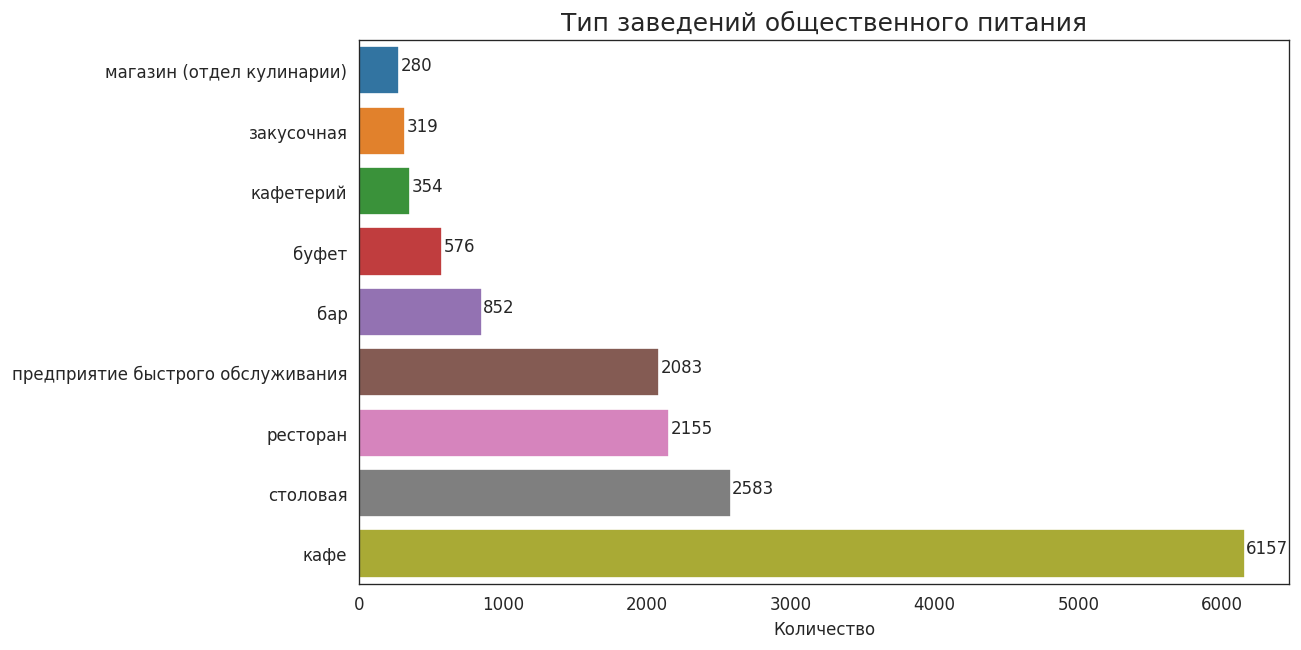

In [34]:
sns.set_style("white")

plt.figure(figsize=(10,6), dpi= 120)

show_values_on_bars(sns.barplot(data = df.groupby('object_type')
                                .agg({'number': 'count'})
                                .reset_index()
                                .sort_values('number'), 
            x='number', y='object_type', orient='h'),
                    h_v='h')

plt.title('Тип заведений общественного питания', fontsize=15)
plt.xlabel("Количество")
plt.ylabel("")
plt.show()

**Абсолютным лидером являются кафе, обходя следующую столовую более чем вдвое, замыкают список отделы кулинарии, закусочные и кафетерии. Так что кафе, которые мы и хотим открыть, вполне подходящая форма**

## Оотношение количества сетевых и несетевых заведений 

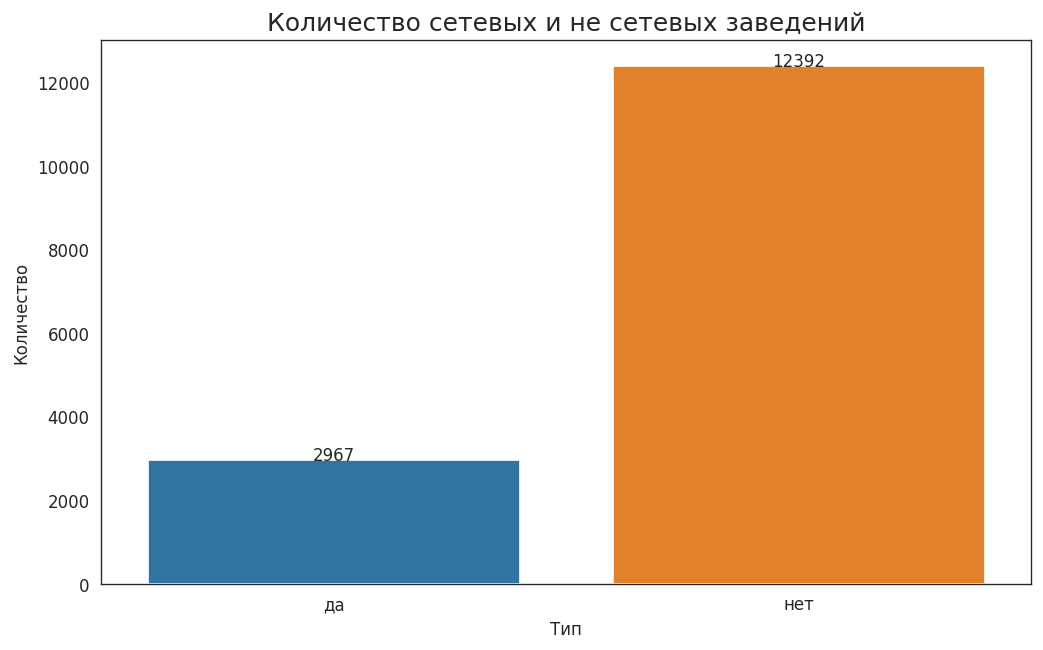

In [35]:
plt.figure(figsize=(10,6), dpi= 120)

show_values_on_bars(sns.barplot(data = df.groupby('chain')
                                .agg({'number': 'count'})
                                .reset_index()
                                .sort_values('number'), 
            x='chain', y='number', orient='v'),
                    h_v='v')

plt.title('Количество сетевых и не сетевых заведений', fontsize=15)
plt.xlabel("Тип")
plt.ylabel("Количество")
plt.show()

Большая часть заведений - одиночные

## Для каких видов объектов характерно сетевое распространение

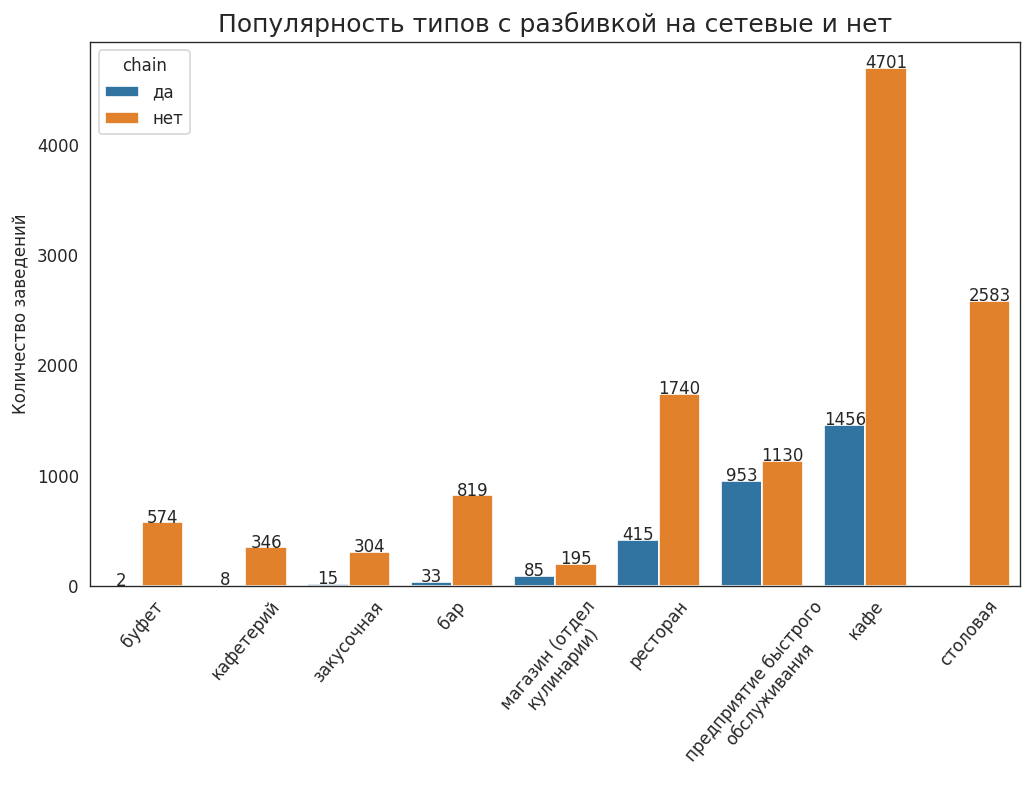

In [36]:
fig = plt.figure(figsize=(10,6), dpi= 120)
ax = fig.add_subplot()

show_values_on_bars(sns.barplot(data = df.groupby(['chain', 'object_type'])
                                .agg({'number': 'count'})
                                .reset_index()
                                .sort_values('number'), 
            x='object_type', y='number', orient='v', hue='chain'),
                    h_v='v')

plt.title('Популярность типов с разбивкой на сетевые и нет', fontsize=15)
plt.xlabel("")
ax.set_xticklabels(textwrap.fill(x.get_text(), 20) for x in ax.get_xticklabels())
plt.xticks(rotation=50)
plt.ylabel("Количество заведений")

plt.show()

In [37]:
tdf = (df.groupby('object_type').agg({'id': 'count', 'chain' : lambda x: (x == "да").sum()})
 .reset_index()
)
tdf['chain_prcnt'] = tdf['chain'] / tdf['id'] * 100
tdf.sort_values('chain_prcnt', ascending=False)

,object_type,id,chain,chain_prcnt
6,предприятие быстрого обслуживания,2083,953,45.751320
5,магазин (отдел кулинарии),280,85,30.357143
3,кафе,6157,1456,23.647880
7,ресторан,2155,415,19.257541
2,закусочная,319,15,4.702194
0,бар,852,33,3.873239
4,кафетерий,354,8,2.259887
1,буфет,576,2,0.347222
8,столовая,2583,0,0.000000


Особенно много сетевых заведений в предприятиях быстрого обслуживания (46%), отделах кулинарии (30%) и кафе (24%). А вот сетевых столовых нет вообще

## Количество мест в зависимости от размера сети 

Посмотрим на относительно крупные сетевые заведения, у которых более 20 филиалов

In [38]:
tdf = (
    df.query('chain == "да"')
    .groupby('object_name')
    .agg({'id' : 'count', 'number' : 'median', 'object_type' : 'first'})
    .reset_index()
    .sort_values('id', ascending=False)
    .query('id >= 20')
)

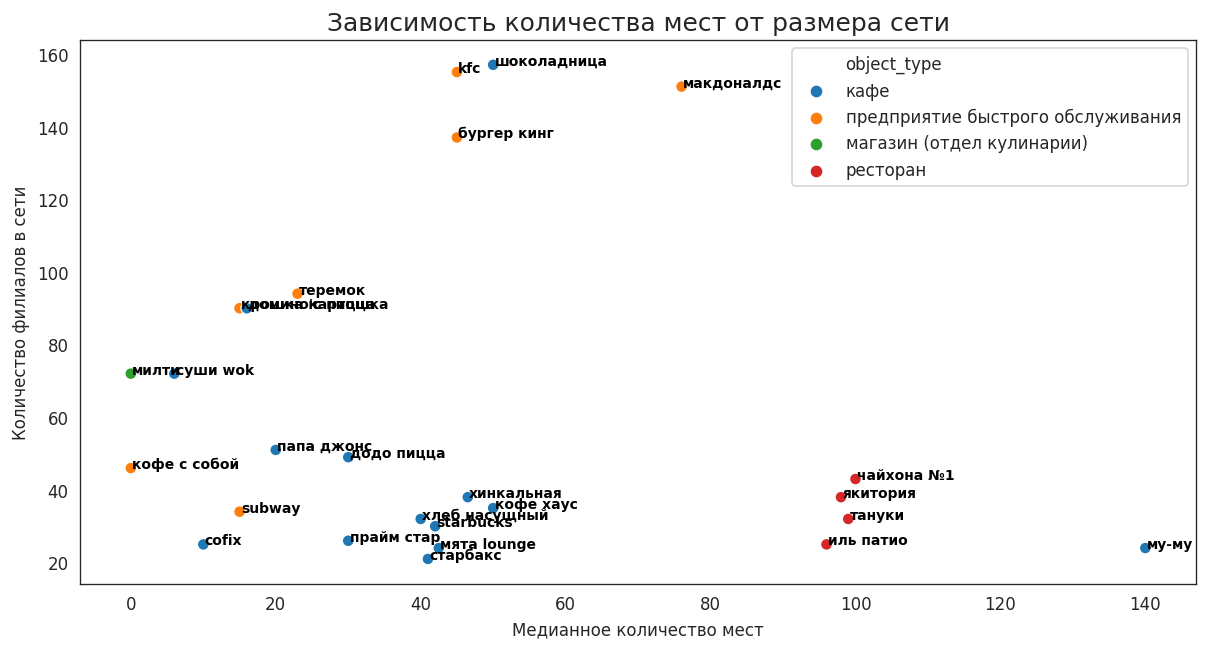

In [39]:
plt.figure(figsize=(12,6), dpi= 120)

sns.scatterplot(data=tdf, x="number", y="id", hue="object_type", s=50)

for line in range(0, tdf.shape[0]):
     plt.text(tdf.iloc[line, 2] + 0.2, 
              tdf.iloc[line, 1], 
              tdf.iloc[line, 0], 
              horizontalalignment='left', 
              size='small', 
              color='black', 
              weight='semibold')

plt.title('Зависимость количества мест от размера сети', fontsize=15)
plt.ylabel("Количество филиалов в сети")
plt.xlabel("Медианное количество мест")
plt.show()

**Заведения достаточно чётко делятся на категории**:  
- **для ресторанов характерен большой размер, но малое количество заведений**;  
- **для фастфуда - среднее количество мест, но много заведений**;  
- **для кафе - небольшие помещения, немного заведений, хотя именно к кафе относятся самая широкая сеть (Шоколадница) и сеть с наибольшим типичным количеством мест (Му-му). Впрочем, это можно объяснить тем, что кафе вообще преобладают над другими типами** 

## Типичное количество мест по типу заведения

In [40]:
tdf = (
    df.groupby('object_type')
    .agg({'number' : 'mean'})
    .reset_index()
    .sort_values('number', ascending=False)
)

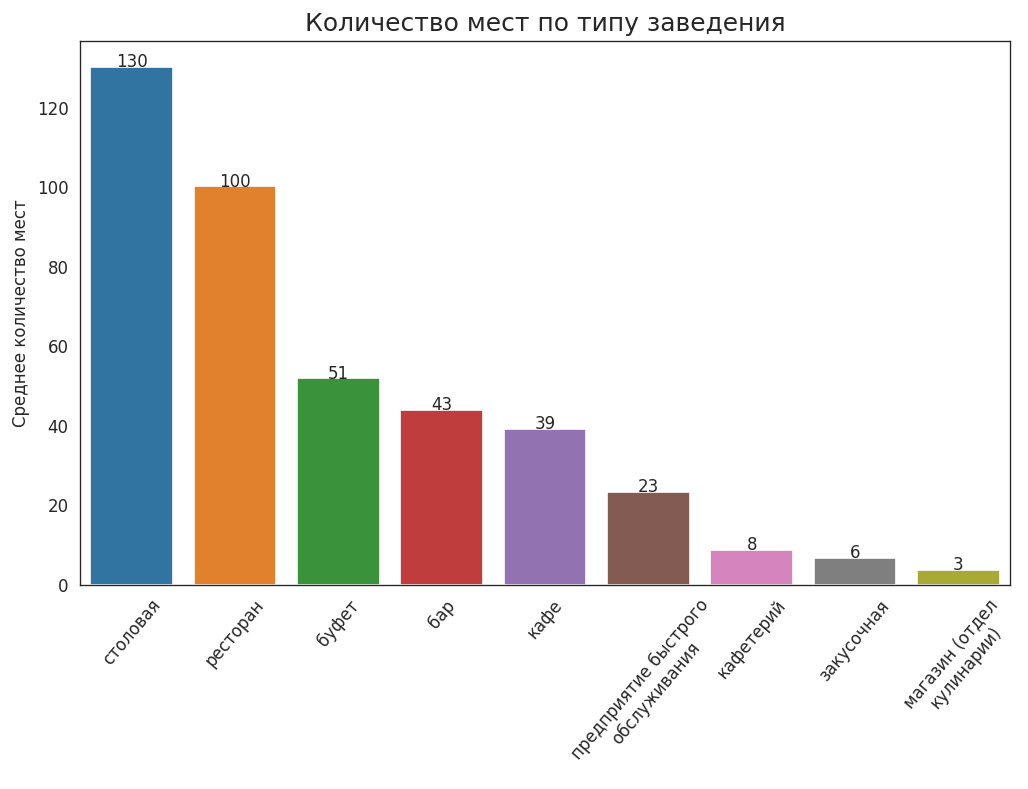

In [41]:
fig = plt.figure(figsize=(10,6), dpi= 120)
ax = fig.add_subplot()

show_values_on_bars(sns.barplot(data = tdf, 
            x='object_type', y='number', orient='v'),
                    h_v='v')

plt.title('Количество мест по типу заведения', fontsize=15)
plt.xlabel("")
plt.ylabel("Среднее количество мест")
ax.set_xticklabels(textwrap.fill(x.get_text(), 20) for x in ax.get_xticklabels())
plt.xticks(rotation=50)

plt.show()

**В среднем самые большие - столовые и рестораны, а кафетерии и фастфуд отличаются малым размером  
Среднее количество мест в кафе, что интересует нас больше всего, 39**

## Название улицы для каждого заведения

In [42]:
df['street'] = df['address'].str.split(',', expand=True)[1].str.lower().str.strip()

In [43]:
df['street'].unique()

array(['улица егора абакумова', 'улица талалихина',
       'абельмановская улица', ..., 'новорижское шоссе',
       'улица василисы кожиной', 'деревня дудкино'], dtype=object)

Посмотрим, как наши объекты распределены на карте  
Границы московских районов возьмём из `http://gis-lab.info/data/mos-adm/mo.geojson`

In [44]:
geomap = gpd.read_file('http://gis-lab.info/data/mos-adm/mo.geojson')

In [45]:
geomap.head(1)

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55.44160, 36.80357 55.45162, 36.81253 55.45140, 36.82745 55.45134, 36.83..."


In [46]:
m1 = folium.Map(location=[55.7522, 37.6156], zoom_start=10)
fg = folium.FeatureGroup(name="районы")


for _, r in geomap.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'white'})
    folium.Popup(r['NAME']).add_to(geo_j)
    geo_j.add_to(fg)

for label, size, color in [
    ('кафе', 'large', '#004f84'), 
    ('столовая', 'large', '#3186cc'),
    ('закусочная', 'medium', '#9c0412'),
    ('предприятие быстрого обслуживания', 'large', '#ffd700'),
    ('ресторан', 'medium', '#dc7fff'),
    ('кафетерий', 'small', '#ec5d2d'),
    ('буфет', 'small', '#009fdc'),
    ('бар', 'medium', '#ffd200'),
    ('магазин (отдел кулинарии)', 'small', '#36896e'),
]:
    market_cluster = MarkerCluster(name=label, icon_create_function = f"""\
function(cluster) {{
    return L.divIcon({{
    html: '<b>' + cluster.getChildCount() + ' {label}',
    className: 'marker-cluster marker-cluster-{size}',
    iconSize: new L.Point(20, 20)
    }});
}}""").add_to(m1)
    for i, row in df.query(f'object_type == "{label}"').iterrows():
        folium.Circle(radius=10, location=[row['lat'], row['long']], popup=row["object_name"], 
                  line_color=color,
                    fill_color=color).add_to(market_cluster)
fg.add_to(m1)
folium.LayerControl().add_to(m1)
m1.save('map_1.html')        


In [3]:
IFrame(src='map_1.html', width='100%', height=500)

Получим для каждого заведения район, в котором оно расположено 

In [48]:
geomap.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long,df.lat))

Возьмём функцию, которая определяет, лежит ли точка в полигоне

In [50]:
def get_pip (gdf, regions):
    r_list = list(regions.NAME)
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        pol = (regions.loc[regions.NAME==r])
        pol.reset_index(drop = True, inplace = True)
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        pip_data = gdf.loc[pip_mask].copy()
        pip_data['region']= r
        df = df.append(pip_data)  
    print('Original dataframe count=',len(gdf),'\nNew dataframe count=', len(df))
    if df.loc[df.id.duplicated() == True].shape[0] > 0:
        print("There are id's with more than one region")
    elif gdf.loc[~gdf.id.isin(df.id)].shape[0] > 0:
        print("There are id's without an assigned region")
    else:
        print("No discrepancies in results!")
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns='geometry')
    return df

In [51]:
eq_df = get_pip(gdf, geomap)

Original dataframe count= 15359 
New dataframe count= 15341
There are id's without an assigned region


Восемнадцати адресам не нашлось своих районов, посмотрим на них

In [52]:
gdf.set_index('id',inplace=True)
eq_df.set_index('id',inplace=True)
newdf=gdf.drop(eq_df.index)

In [53]:
newdf

,object_name,chain,object_type,address,number,Url_With_Coordinates,lat,long,street,geometry
id,,,,,,,,,,
77765,оазис внуково,нет,ресторан,"город Москва, поселение Московский, деревня Лапшинка, дом 2Б",80,https://maps.google.com/maps/api/staticmap?center=64.3933983%2C105.30795455&zoom=3&size=256x256&language=en&sensor=f...,64.393398,105.307955,поселение московский,POINT (105.30795 64.39340)
89416,kfc,да,предприятие быстрого обслуживания,"город Москва, 82-й километр Московской Кольцевой Автодороги, владение 18",94,https://maps.google.com/maps/api/staticmap?center=55.6251158%2C37.7985498&zoom=17&size=256x256&language=en&sensor=fa...,55.625116,37.798550,82-й километр московской кольцевой автодороги,POINT (37.79855 55.62512)
138207,самарканд,нет,кафе,"город Москва, 82-й километр Московской Кольцевой Автодороги, владение 18",90,https://maps.google.com/maps/api/staticmap?center=55.6251158%2C37.7985498&zoom=17&size=256x256&language=en&sensor=fa...,55.625116,37.798550,82-й километр московской кольцевой автодороги,POINT (37.79855 55.62512)
144799,кафе на азс,нет,закусочная,"город Москва, 67-й километр Московской Кольцевой Автодороги, дом 7",2,https://maps.google.com/maps/api/staticmap?center=55.817014%2C37.3901368&zoom=14&size=256x256&language=en&sensor=fal...,55.817014,37.390137,67-й километр московской кольцевой автодороги,POINT (37.39014 55.81701)
71261,кафе «загорье»,нет,кафе,"город Москва, 28-й километр Московской Кольцевой Автодороги, владение 7",48,https://maps.google.com/maps/api/staticmap?center=55.8066394%2C37.3860564&zoom=17&size=256x256&language=en&sensor=fa...,55.806639,37.386056,28-й километр московской кольцевой автодороги,POINT (37.38606 55.80664)
79701,ресторан «заречье»,нет,ресторан,"город Москва, город Троицк, 1-й Заречный переулок, дом 17",47,https://maps.google.com/maps/api/staticmap?center=54.3329955%2C41.25821245&zoom=7&size=256x256&language=en&sensor=fa...,54.332996,41.258212,город троицк,POINT (41.25821 54.33300)
127410,московский,нет,ресторан,"город Москва, город Московский, 1-й микрорайон, дом 5",70,https://maps.google.com/maps/api/staticmap?center=55.79376875%2C37.295872&zoom=10&size=256x256&language=en&sensor=fa...,55.793769,37.295872,город московский,POINT (37.29587 55.79377)
80070,кафе-блинная сударушка,нет,кафе,"город Москва, поселение Рязановское, посёлок Фабрики имени 1 Мая, дом 3",20,https://maps.google.com/maps/api/staticmap?center=64.3933983%2C105.30795455&zoom=3&size=256x256&language=en&sensor=f...,64.393398,105.307955,поселение рязановское,POINT (105.30795 64.39340)
147763,чайхона,нет,кафе,"город Москва, город Щербинка, Варшавское шоссе, 28-й километр, владение 8, строение 1",65,https://maps.google.com/maps/api/staticmap?center=55.5725469%2C37.60667895&zoom=13&size=256x256&language=en&sensor=f...,55.572547,37.606679,город щербинка,POINT (37.60668 55.57255)


Адреса на мкаде и новой Москве. Так как они явно не нужны для нашего анализа, оставим как есть

## Топ10 улиц, топ10 районов

In [54]:
df = eq_df.copy().reset_index()

In [55]:
t = (df.query('street != "город зеленоград" and street != "поселение сосенское"')
     .groupby(['street'])
     .agg({'region' : 'unique', 'number' : 'count'})
     .reset_index()
     .sort_values('number', ascending=False)
    )

Посмотрим на топ10 улиц по количеству объектов и районы, через которые они идут 

*В Зеленограде по историческим причинам нет, фактически, улиц, поэтому он попал в список в таком качестве, как и в поселении Сосенское, исключим их из рассмотрения*  

In [56]:
top10 = t['region'].head(10)
top10_streets = t['street'].head(10)

t.head(10)

,street,region,number
1117,проспект мира,"[Останкинский, Свиблово, Мещанский, Ростокино, Алексеевский, Ярославский]",204
1121,профсоюзная улица,"[Тёплый Стан, Черёмушки, Обручевский, Ясенево, Коньково, Академический]",182
744,ленинградский проспект,"[Сокол, Хорошёвский, Беговой, Аэропорт]",171
1078,пресненская набережная,[Пресненский],165
415,варшавское шоссе,"[Южное Бутово, Чертаново Центральное, Чертаново Южное, Чертаново Северное, Донской, Нагорный, Нагатино-Садовники]",161
747,ленинский проспект,"[Тёплый Стан, Ломоносовский, Тропарёво-Никулино, Обручевский, Проспект Вернадского, Гагаринский, Якиманка, Донской]",147
1114,проспект вернадского,"[Ломоносовский, Тропарёво-Никулино, Раменки, Проспект Вернадского, Гагаринский]",132
735,кутузовский проспект,"[Фили-Давыдково, Дорогомилово]",114
660,каширское шоссе,"[Нагатино-Садовники, Москворечье-Сабурово, Орехово-Борисово Северное, Орехово-Борисово Южное]",112
666,кировоградская улица,"[Чертаново Центральное, Чертаново Южное, Чертаново Северное]",110


**Довольно непонятный на первый взгляд список, наличие улиц в котором обусловлено не их особенной привлекательностью, а длинной**  

**Также интересно посмотреть на более релевантную, кажется, информацию по топ10 районам без привязки к улицам**

In [57]:
t = df.groupby(['region']).agg({'number' : 'count'}).reset_index().sort_values('number')
top10_reg = t["region"].tail(10)
top10_reg

130      Хорошёвский
4              Арбат
67         Мещанский
117        Таганский
127        Хамовники
34     Замоскворечье
29       Даниловский
7          Басманный
94       Пресненский
118         Тверской
Name: region, dtype: object

**Вот в таком виде список кажется более разумным: центральные районы, самые обычные места для отдыха**

In [58]:
a = list(top10)
top10_list = [i for sublist in a for i in sublist]

In [59]:
m3 = folium.Map(location=[55.7522, 37.6156], zoom_start=10)

fg = folium.FeatureGroup(name="районы с популярной улицей")
m3.add_child(fg)

fg1 = folium.FeatureGroup(name="популярные районы")
m3.add_child(fg1)


for _, r in geomap.query('NAME in @top10_list').iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'white'}, name=r['NAME'])
    folium.Popup(r['NAME']).add_to(geo_j)
    geo_j.add_to(fg)
    
for _, r in geomap.query('NAME in @top10_reg').iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'blue'}, name=r['NAME'])
    folium.Popup(r['NAME']).add_to(geo_j)
    geo_j.add_to(fg1)

folium.LayerControl().add_to(m3)

m3.save('map_2.html')


In [4]:
IFrame(src='map_2.html', width='100%', height=500)

Да, наиболее популярны центральные районы, что неудивительно, а самые популярные улицы проходят через следующие районы:

In [61]:
[i for i in set(top10_list)]

['Коньково',
 'Орехово-Борисово Северное',
 'Раменки',
 'Гагаринский',
 'Тёплый Стан',
 'Черёмушки',
 'Пресненский',
 'Нагатино-Садовники',
 'Беговой',
 'Алексеевский',
 'Академический',
 'Ясенево',
 'Аэропорт',
 'Свиблово',
 'Чертаново Южное',
 'Ломоносовский',
 'Тропарёво-Никулино',
 'Нагорный',
 'Фили-Давыдково',
 'Орехово-Борисово Южное',
 'Мещанский',
 'Чертаново Центральное',
 'Проспект Вернадского',
 'Донской',
 'Останкинский',
 'Хорошёвский',
 'Ростокино',
 'Сокол',
 'Чертаново Северное',
 'Дорогомилово',
 'Москворечье-Сабурово',
 'Ярославский',
 'Южное Бутово',
 'Якиманка',
 'Обручевский']

## Улицы только с одним заведением и их районы

In [62]:
mask = (df.groupby('street')
        .agg({'number' : 'count', 'region' : 'first'})
        .query('number == 1')
        .reset_index()
        .sort_values('number', ascending=False)
       )

In [63]:
mask.shape

(579, 3)

Всего в нашем датасете есть 579 улиц только с одним лишь заведением, посмотрим, в каких районах их больше

In [64]:
empty_street_counter = (mask.groupby('region')
                        .agg({'number' : 'count'})
                        .reset_index()
                        .sort_values('number', ascending=False)
                       )
empty_street_counter.head(10)


,region,number
88,Таганский,33
96,Хамовники,27
71,Пресненский,24
6,Басманный,23
89,Тверской,21
47,Марьина Роща,17
84,Сокольники,15
50,Мещанский,14
25,Замоскворечье,13
41,Лефортово,12


Опять много центральных районов. Возможно, связано с тем, что улицы в центре обычно намного короче. Посмотрим на карте

In [65]:
streets_total = df.groupby('region').agg({'street' : 'nunique'}).reset_index()
streets_total.rename(columns={'street':'streets_total'}, inplace=True)
streets_total.head()

,region,streets_total
0,"""Мосрентген""",4
1,Академический,11
2,Алексеевский,19
3,Алтуфьевский,8
4,Арбат,35


In [66]:
all_regions = pd.DataFrame(df['region'].unique())

In [67]:
every_empty_street_counter = streets_total.merge(empty_street_counter, how='left', on='region')

In [68]:
every_empty_street_counter.head()

,region,streets_total,number
0,"""Мосрентген""",4,2.0
1,Академический,11,NaN
2,Алексеевский,19,7.0
3,Алтуфьевский,8,2.0
4,Арбат,35,11.0


Присоединим данные о количестве улиц с одним заведением и количестве улиц на которых есть хоть что-то к датафрейму с районами

In [69]:
geomap = geomap.merge(every_empty_street_counter, how='left', left_on='NAME', right_on='region')

In [70]:
geomap.fillna(0, inplace = True)

In [71]:
colormap = linear.YlGn_09.scale(
    geomap.streets_total.min(), log(geomap.streets_total.max())
)
colormap.caption="Улиц с одним заведением"

colormap2 = linear.YlGn_09.scale(
    geomap.streets_total.min(), log(geomap.streets_total.max())
)
colormap.caption="Всего улиц в районе"

m = folium.Map(location=[55.7522, 37.6156], zoom_start=10) 

tategeo = folium.GeoJson(geomap,
                          name='Empty streets',
                          style_function=lambda x: {'fillColor': colormap(log(x['properties']['number'] + 1)), 
                                                    'color': 'black',
                                                    'weight':2, 'fillOpacity':0.5},
                          tooltip=folium.GeoJsonTooltip(fields=['NAME', 'number'], 
                                            aliases=['Name', 'Empty streets'], 
                                            localize=True)
                         ).add_to(m)

tategeo = folium.GeoJson(geomap,
                          name='Streets total',
                          style_function=lambda x: {'fillColor': colormap2(log(x['properties']['streets_total'])), 
                                                    'color': 'black',
                                                    'weight':2, 'fillOpacity':0.5},
                          tooltip=folium.GeoJsonTooltip(fields=['NAME', 'streets_total'], 
                                            aliases=['Name', 'Streets total'], 
                                            localize=True)
             ).add_to(m)
folium.LayerControl().add_to(m)
colormap2.add_to(m)
colormap.add_to(m)
m.save('map_streets_1.html')


In [72]:
IFrame(src='map_streets_1.html', width='100%', height=500)

**Видно, что переключая слои общая картина не меняется: отношение $\large  \frac{всего~улиц~с~заведениями~питания}{улиц~с~одним~заведением~питания}$ примерно одинаково**  


## Общее количество заведений в районе

Посмотрим на общую картину, в какой районе сколько заведений общественного питания

In [73]:
ids_total = df.groupby('region').agg({'id' : 'count'}).reset_index().sort_values('id')

In [74]:
geomap = geomap.merge(ids_total, left_on='NAME', right_on='region')

In [75]:
colormap = linear.YlGn_09.scale(
    geomap.id.min(), log(geomap.id.max())
)
colormap.caption="Всего заведений в районе"

m = folium.Map(location=[55.7522, 37.6156], zoom_start=10) 

tategeo = folium.GeoJson(geomap,
                          name='Eaterys total',
                          style_function=lambda x: {'fillColor': colormap(log(x['properties']['id'])), 
                                                    'color': 'black',
                                                    'weight':2, 'fillOpacity':0.5},
                          tooltip=folium.GeoJsonTooltip(fields=['NAME', 'id'], 
                                            aliases=['Name', 'Eaterys_count'], 
                                            localize=True)
             ).add_to(m)
folium.LayerControl().add_to(m)

colormap.add_to(m)
m.save('map_eaterys_count.html')


In [76]:
IFrame(src='map_eaterys_count.html', width='100%', height=500)

## Распределение количества посадочных мест для улиц с большим количеством объектов

In [77]:
tdf = (
    df.query('street in @top10_streets')
    .groupby('street')
    .agg({'number' : 'median'})
    .reset_index()
    .sort_values('number', ascending=False)
    .head(10)
)

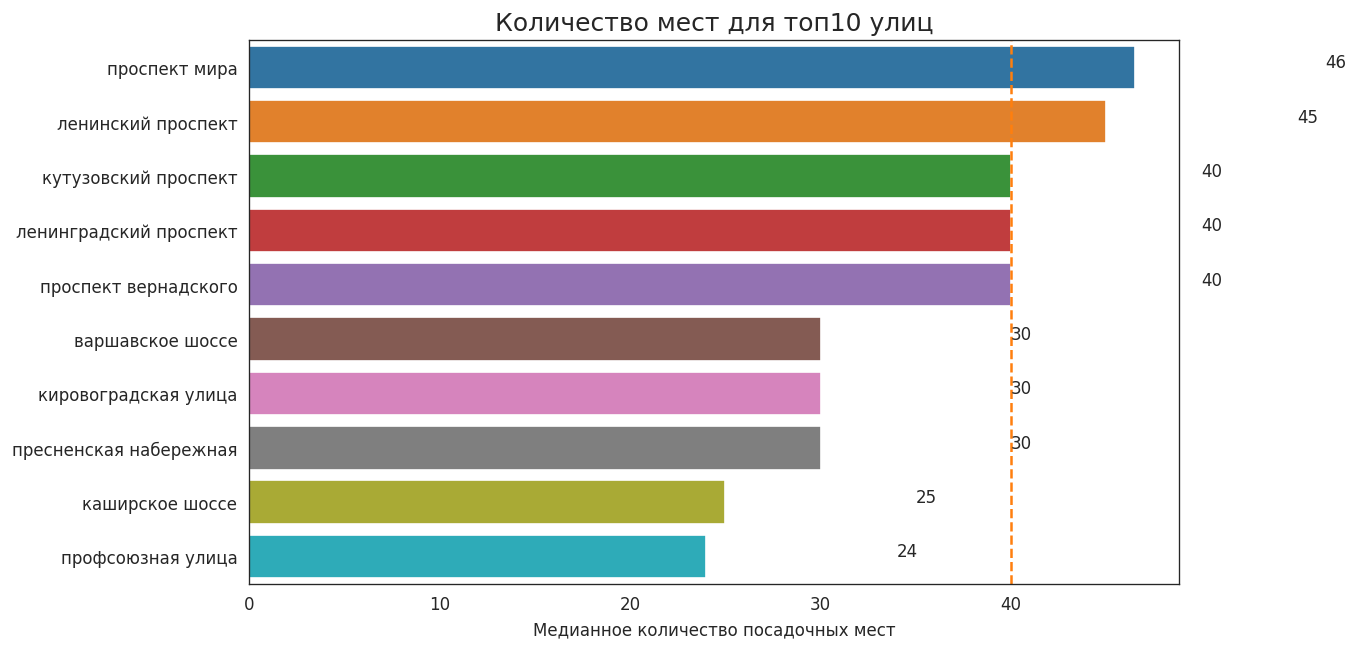

In [78]:
plt.figure(figsize=(10,6), dpi= 120)

show_values_on_bars(sns.barplot(data = tdf, 
            x='number', y='street', orient='h'),
                    h_v='h')

plt.title('Количество мест для топ10 улиц', fontsize=15)
plt.xlabel("Медианное количество посадочных мест")
plt.ylabel("")
plt.axvline(x=40, color=sns.color_palette()[1], linestyle='--')

plt.show()

Какой-то общей картины не видно: медиана для всей Москвы 40, топ улиц отличается слабо и в обе стороны, закономерности не видно  
Сосенское выделяется по понятной причине: Москвой его можно считать только формально 

In [79]:
tdf = (
    df.query('region in @top10_reg')
    .groupby('region')
    .agg({'number' : 'median'})
    .reset_index()
    .sort_values('number', ascending=False)
    .head(10)
)

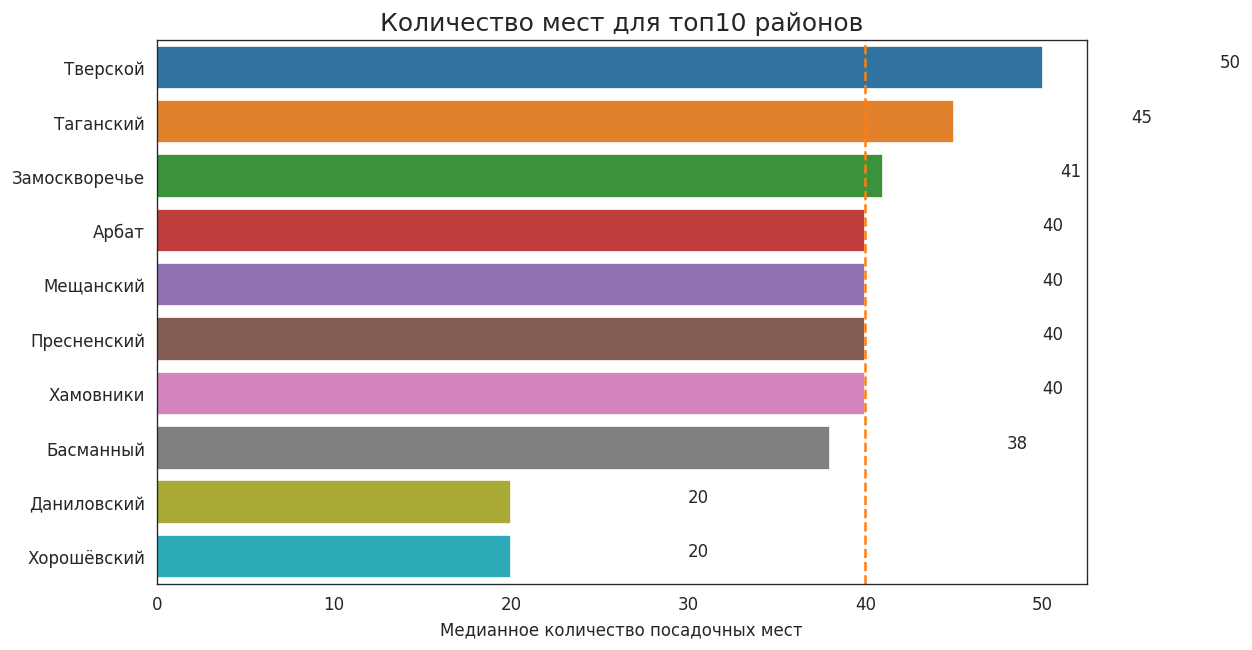

In [80]:
plt.figure(figsize=(10,6), dpi= 120)

show_values_on_bars(sns.barplot(data = tdf, 
            x='number', y='region', orient='h'),
                    h_v='h')

plt.title('Количество мест для топ10 районов', fontsize=15)
plt.xlabel("Медианное количество посадочных мест")
plt.ylabel("")
plt.axvline(x=40, color=sns.color_palette()[1], linestyle='--')

plt.show()

Картина похожая на прошлый график, хотя Даниловский и Хорошёвский районы возможно оказались вместе не случайно: это наиболее удалённые от центра из десяти 

Посмотрим на это на карте

In [81]:
median_seats = (
    df.groupby('region')
    .agg({'number' : 'median'})
    .reset_index()
    .sort_values('number', ascending=False)
)

median_seats.rename(columns={'number':'median_seats_count'}, inplace=True)

median_seats.head(5)

,region,median_seats_count
99,Рязановское,159.5
43,Кокошкино,107.0
81,Новокосино,100.0
24,Восточный,100.0
79,Ново-Переделкино,94.0


In [82]:
geomap = geomap.merge(median_seats, left_on='NAME', right_on='region')

In [83]:
colormap = linear.YlGn_09.scale(
    log(geomap.median_seats_count.min()), log(geomap.median_seats_count.max())
)
colormap.caption="Медианное количество мест"

m = folium.Map(location=[55.7522, 37.6156], zoom_start=10) 

tategeo = folium.GeoJson(
    geomap,
    name='Районы Москвы',
    style_function=lambda x: {'fillColor': colormap(log(x['properties']['median_seats_count'])), 
    'color': 'black',
    'weight':2, 'fillOpacity':0.5},
    tooltip=folium.GeoJsonTooltip(fields=['NAME', 'median_seats_count'], 
                                            aliases=['Name', 'Seats median'], 
                                            localize=True)
                         ).add_to(m)

colormap.add_to(m)
m.save('map_seats_1.html')

In [84]:
IFrame(src='map_seats_1.html', width='100%', height=500)

Да, серьёзной зависимости не видно. Среднее количество мест от удалённости от центра вряд ли зависит 

In [85]:
tdf = (
    df.groupby('object_type')
    .agg({'number' : 'mean'})
    .reset_index()
    .sort_values('number', ascending=False)
)
tdf

,object_type,number
8,столовая,130.275261
7,ресторан,100.226871
1,буфет,51.855903
0,бар,43.913146
3,кафе,39.025374
6,предприятие быстрого обслуживания,23.293891
4,кафетерий,8.768362
2,закусочная,6.657233
5,магазин (отдел кулинарии),3.700000


# Вывод

Наиболее популярные типы заведений - кафе, столовая, ресторан;  
Сетевая модель распространения характерна для предприятий быстрого обслуживания (46%), отделов кулинарии (30%) и кафе (24%);  
Для сетевых заведений наблюдается следующая закономерность:  
* для ресторанов характерен большой размер, но малое количество заведений;  
* для фастфуда - среднее количество мест, но много заведений;  
* для кафе - небольшие помещения, немного заведений  


Типичное количество мест для кафе - 39, для ресторанов 100, для столовых 130;  
Районы с наибольшим количеством объектов питания - центральные;  
Медианное количество посадочных мест примерно одинаково для всех районов 

**Исследование можно обобщить таким образом:**  
- кафе является хорошим вариантом как для сетевого, так и для одиночного заведения, на их рынке много, спрос есть  
- количество посадочных мест стоит выбирать опираясь на вид заведения. Если это кафе, то оптимально около сорока
- район лучше выбирать центральный, один из входящих в десятку по количеству заведений. Обслуживание роботами скорее всего долгое время будет обходится дороже, чем людьми, а туристические районы города лучшее место для дорогого заведения  
- какие-то прогнозы о возможности создания сети строить сложно: примеры успешных сетевых кафе в Москве есть, но решающую роль будет играть то, насколько эффективно у нас получится использовать роботизированных официантов. Если их эксплуатация будет очень дорогой, то открывать филиалы будет вредно: люди будут ходить в наше кафе не зна едой, а за экзотикой. Вывести экзотику на широкий рынок можно только тогда, когда это экономически обоснованно